In [81]:
!pip3 install seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.gridspec as gridspec
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Plot settings
# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

# LaTeX-Schriftart für Matplotlib aktivieren
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern für mathematischen Text

In [83]:
def analyze_pairs(price_matrix, pvalue_threshold=0.05, symbols=None):
    """
    Analysiert Paare auf Cointegration.
    
    Parameters:
    price_matrix (DataFrame): Matrix mit Preisdaten
    pvalue_threshold (float): Signifikanzschwelle für den p-Wert
    symbols (list): Liste von Symbolen, die berücksichtigt werden sollen (optional)
    
    Returns:
    tuple: score_matrix, pvalue_matrix, pairs, symbols
    """
    if symbols is None:
        symbols = price_matrix.columns.tolist()
    
    return find_cointegrated_pairs(price_matrix, pvalue_threshold, symbols)

In [84]:
# Zeiträume konfigurieren
TRAIN_START = pd.Timestamp('2021-02-02')
TRAIN_END = pd.Timestamp('2024-01-01')
TEST_END = pd.Timestamp('2025-01-01')
TRADING_DAYS_PER_YEAR = 252

DATE_CONFIG = {
    'TRAIN_START': TRAIN_START,
    'TRAIN_END': TRAIN_END,
    'TEST_END': TEST_END,
    'TRADING_DAYS_PER_YEAR': TRADING_DAYS_PER_YEAR  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

In [85]:
def load_and_prepare_data(file_path):
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    # Fehlende Werte auffüllen
    price_matrix = price_matrix.ffill().bfill()
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Daten geladen von {DATE_CONFIG['TRAIN_START']} bis {DATE_CONFIG['TEST_END']}")
    print(f"Anzahl Symbole: {len(symbols)}")
    print(f"Anzahl Handelstage: {len(price_matrix)}")
    
    return price_matrix, symbols

In [86]:
def find_cointegrated_pairs(price_matrix, p_threshold=0.05, symbols=None):
    """
    Findet cointegrierte Paare in der Preismatrix.
    Verwendet zufällige Paarauswahl und gibt auch die Ergebnisse in zufälliger Reihenfolge zurück.
    
    Parameters:
    price_matrix (DataFrame): Matrix mit Preisdaten
    p_threshold (float): Signifikanzschwelle für den p-Wert
    symbols (list): Liste von Symbolen, die berücksichtigt werden sollen (optional)
    
    Returns:
    tuple: score_matrix, pvalue_matrix, pairs, random_symbols
    """
    if symbols is None:
        symbols = price_matrix.columns.tolist()
    
    # Wichtig: Filtere die Preismatrix, um nur die angegebenen Symbole zu verwenden
    price_matrix_filtered = price_matrix[symbols]
    
    # Symbole zufällig anordnen
    import random
    random_symbols = list(symbols)
    random.shuffle(random_symbols)
    
    n = len(random_symbols)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []
    
    # Fortschrittsbalken für die Berechnung
    total_combinations = n * (n - 1) // 2
    with tqdm(total=total_combinations, desc="Berechne Cointegration") as pbar:
        for i in range(n):
            for j in range(i+1, n):
                s1 = price_matrix_filtered[random_symbols[i]]
                s2 = price_matrix_filtered[random_symbols[j]]
                
                # NaN-Werte entfernen
                valid = ~(np.isnan(s1) | np.isnan(s2))
                if valid.sum() <= 1:
                    pbar.update(1)
                    continue
                    
                s1 = s1[valid]
                s2 = s2[valid]
                
                # Augmented Dickey-Fuller-Test durchführen
                result = coint(s1, s2)
                score = result[0]
                pvalue = result[1]
                
                score_matrix[i, j] = score
                score_matrix[j, i] = score
                pvalue_matrix[i, j] = pvalue
                pvalue_matrix[j, i] = pvalue
                
                if pvalue < p_threshold:
                    # Hier wird das Paar zur Liste hinzugefügt
                    pairs.append((random_symbols[i], random_symbols[j]))
                
                pbar.update(1)
    
    # Wichtig: Die Anzahl der Paare sollte mit der Summe der p-Werte unter dem Schwellenwert übereinstimmen
    expected_pairs = sum(1 for i in range(n) for j in range(i+1, n) if pvalue_matrix[i, j] < p_threshold)
    print(f"Anzahl gefundener Paare: {len(pairs)}, Erwartete Anzahl: {expected_pairs}")
    
    # Wichtig: Wir geben jetzt die zufälligen Symbole zurück, nicht die originalen
    return score_matrix, pvalue_matrix, pairs, random_symbols

In [87]:
def plot_combined_heatmaps(result_market1, result_market2, 
                        market_name1="FTSE", market_name2="NASDAQ", 
                        p_threshold=0.05, max_symbols=None, cmap="viridis", figsize=(22, 10)):
    """
    Erstellt zwei Heatmaps nebeneinander mit einer gemeinsamen Legende.
    
    Parameters:
    result_market1, result_market2: Ergebnistupel aus der Cointegration-Analyse
    market_name1, market_name2: Namen der Märkte
    p_threshold: Signifikanzschwelle (nur für den Titel)
    max_symbols: Optional, begrenzt die Anzahl der angezeigten Symbole in der Visualisierung
    cmap: Farbpalette für die Heatmap
    figsize: Größe der Gesamtfigur
    
    Returns:
    fig, (ax1, ax2): Die erstellte Figure und die Axes-Objekte
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.colors import Normalize
    
    score_matrix1, pvalue_matrix1, pairs1, symbols1 = result_market1
    score_matrix2, pvalue_matrix2, pairs2, symbols2 = result_market2
    
    # Optional: Begrenze die Anzahl der Symbole für bessere Lesbarkeit in der Visualisierung
    # Dies hat keinen Einfluss auf die Berechnung, nur auf die Darstellung
    if max_symbols and len(symbols1) > max_symbols:
        display_symbols1 = symbols1[:max_symbols]
        display_pvalue_matrix1 = pvalue_matrix1[:max_symbols, :max_symbols]
    else:
        display_symbols1 = symbols1
        display_pvalue_matrix1 = pvalue_matrix1
        
    if max_symbols and len(symbols2) > max_symbols:
        display_symbols2 = symbols2[:max_symbols]
        display_pvalue_matrix2 = pvalue_matrix2[:max_symbols, :max_symbols]
    else:
        display_symbols2 = symbols2
        display_pvalue_matrix2 = pvalue_matrix2
    
    # Anzahl der signifikanten Paare
    num_pairs1 = sum(1 for i in range(len(symbols1)) for j in range(i+1, len(symbols1)) 
                     if pvalue_matrix1[i, j] < p_threshold)
    num_pairs2 = sum(1 for i in range(len(symbols2)) for j in range(i+1, len(symbols2)) 
                     if pvalue_matrix2[i, j] < p_threshold)
    
    # Dreieck-Masken erstellen (nur unteres Dreieck anzeigen)
    mask1 = np.triu(np.ones_like(display_pvalue_matrix1, dtype=bool))
    mask2 = np.triu(np.ones_like(display_pvalue_matrix2, dtype=bool))
    
    # Erstelle Figure mit zwei Subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Weißen Hintergrund setzen
    fig.patch.set_facecolor('white')
    
    # Normalisierung für beide Heatmaps (gemeinsame Farbskala)
    vmin = min(np.min(display_pvalue_matrix1), np.min(display_pvalue_matrix2))
    vmax = max(np.max(display_pvalue_matrix1), np.max(display_pvalue_matrix2))
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Erste Heatmap mit schwarzem Rand
    hm1 = sns.heatmap(display_pvalue_matrix1, 
                     mask=mask1,
                     cmap=cmap, 
                     square=True, 
                     linewidths=0.1,
                     cbar=False,  # Keine Legende für die erste Heatmap
                     xticklabels=display_symbols1,
                     yticklabels=display_symbols1,
                     norm=norm,
                     ax=ax1)
    
    # Schwarzen Rand für die erste Heatmap
    for _, spine in ax1.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(3.5)
    
    # Zweite Heatmap mit gemeinsamer Legende
    hm2 = sns.heatmap(display_pvalue_matrix2, 
                     mask=mask2,
                     cmap=cmap, 
                     square=True, 
                     linewidths=0.1,
                     cbar_kws={"shrink": 0.9, 
                              "label": "p-value",
                              "aspect": 15},  # Breite der Colorbar anpassen
                     xticklabels=display_symbols2,
                     yticklabels=display_symbols2,
                     norm=norm,
                     ax=ax2)
    
    # Schwarzen Rand für die zweite Heatmap
    for _, spine in ax2.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(3.5)
    
    # Größe der Tick-Labels in der Colorbar anpassen NACH dem Erstellen der Heatmap
    cbar = ax2.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)  # Größere Tick-Labels in der Colorbar
    cbar.set_label("p-value", fontsize=30)  # Größere Beschriftung der Colorbar
    
    # Beschriftungen anpassen
    for ax in [ax1, ax2]:
        plt.sca(ax)
        plt.xticks(fontsize=20, rotation=90)
        plt.yticks(fontsize=20)
        ax.set_xlabel("Symbol", fontsize=30)
    
    # Nur für die erste Achse Y-Label setzen
    ax1.set_ylabel("Symbol", fontsize=30)
    
    # Titel hinzufügen mit Anzeige der Stichprobengröße
    ax1.set_title(f"{market_name1} - Cointegration (n={len(symbols1)})\n({num_pairs1} Pairs found with p < {p_threshold})", fontsize=30, pad=20)
    ax2.set_title(f"{market_name2} - Cointegration (n={len(symbols2)})\n({num_pairs2} Pairs found with p < {p_threshold})", fontsize=30, pad=20)
    
    # Layout optimieren
    plt.tight_layout()
    
    return fig, (ax1, ax2)

Daten geladen von 2021-02-02 00:00:00 bis 2025-01-01 00:00:00
Anzahl Symbole: 98
Anzahl Handelstage: 987
Anzahl der ausgewählten FTSE-Symbole: 30


Berechne Cointegration: 100%|██████████| 435/435 [00:03<00:00, 110.29it/s]


Anzahl gefundener Paare: 57, Erwartete Anzahl: 57
Daten geladen von 2021-02-02 00:00:00 bis 2025-01-01 00:00:00
Anzahl Symbole: 94
Anzahl Handelstage: 985
Anzahl der ausgewählten NASDAQ-Symbole: 30


Berechne Cointegration: 100%|██████████| 435/435 [00:03<00:00, 111.96it/s]


Anzahl gefundener Paare: 28, Erwartete Anzahl: 28
FTSE Matrix-Größe: (30, 30), erwartet: (30, 30)
NASDAQ Matrix-Größe: (30, 30), erwartet: (30, 30)


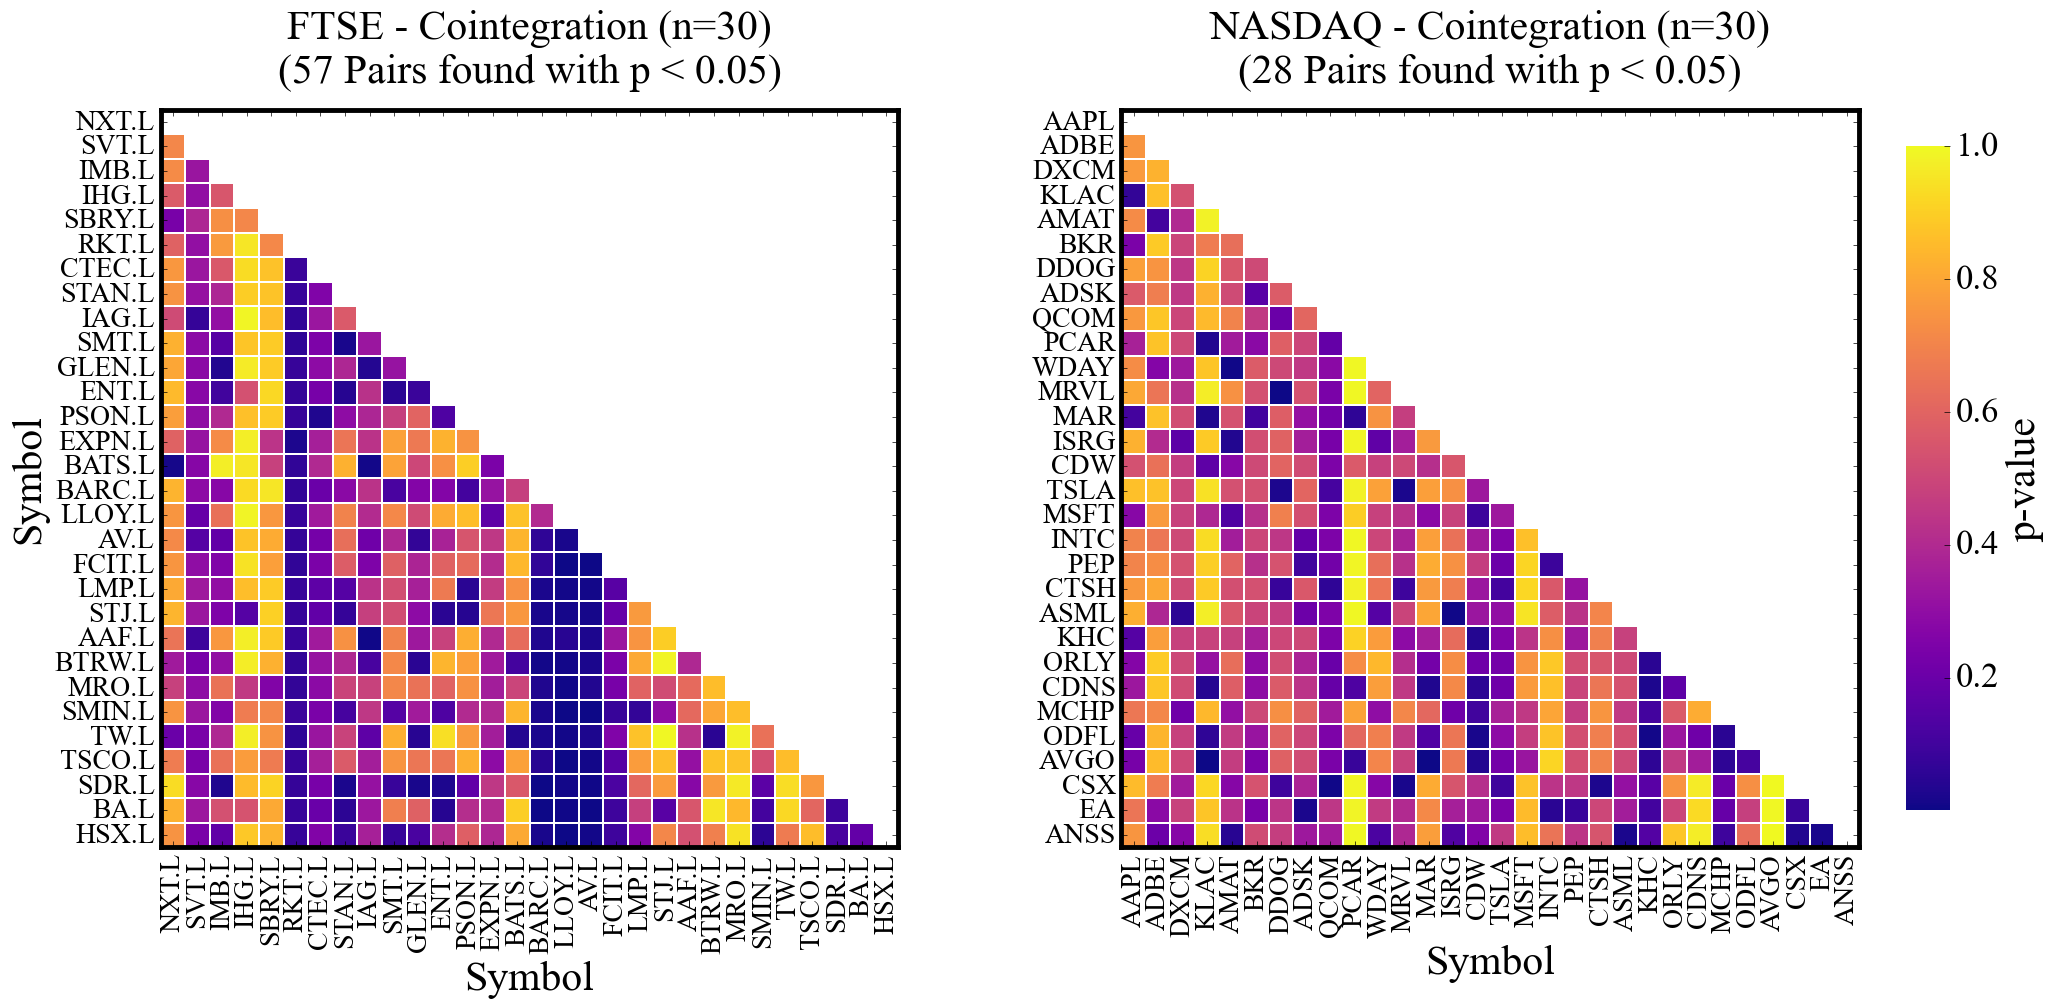

In [89]:
# Diese Zelle führt die gesamte Analyse durch

# Anzahl der zu analysierenden Symbole festlegen
max_symbols = 30  # Dieser Wert kann angepasst werden

# FTSE-Daten laden
price_matrix_ftse, symbols_ftse = load_and_prepare_data('../../data/raw/ftse_daily.parquet')

# Training-Zeitraum auswählen
train_period = get_training_period()
train_mask = (price_matrix_ftse.index >= train_period['start']) & (price_matrix_ftse.index <= train_period['end'])
price_matrix_ftse_train = price_matrix_ftse[train_mask]

# Zufällige Auswahl der Symbole für FTSE
import random
random.seed(50)  # Für Reproduzierbarkeit
if max_symbols and len(symbols_ftse) > max_symbols:
    random_symbols_ftse = random.sample(symbols_ftse, max_symbols)
else:
    random_symbols_ftse = symbols_ftse.copy()  # Kopie erstellen, um das Original nicht zu modifizieren

print(f"Anzahl der ausgewählten FTSE-Symbole: {len(random_symbols_ftse)}")

# Cointegration für FTSE berechnen
result_ftse = analyze_pairs(price_matrix_ftse_train, pvalue_threshold=0.05, symbols=random_symbols_ftse)
score_matrix_ftse, pvalue_matrix_ftse, pairs_ftse, symbols_ftse_random = result_ftse

# NASDAQ-Daten laden
price_matrix_nasdaq, symbols_nasdaq = load_and_prepare_data('../../data/raw/nasdaq_daily.parquet')

# Training-Zeitraum auswählen
train_mask = (price_matrix_nasdaq.index >= train_period['start']) & (price_matrix_nasdaq.index <= train_period['end'])
price_matrix_nasdaq_train = price_matrix_nasdaq[train_mask]

# Zufällige Auswahl der Symbole für NASDAQ
if max_symbols and len(symbols_nasdaq) > max_symbols:
    random_symbols_nasdaq = random.sample(symbols_nasdaq, max_symbols)
else:
    random_symbols_nasdaq = symbols_nasdaq.copy()

print(f"Anzahl der ausgewählten NASDAQ-Symbole: {len(random_symbols_nasdaq)}")

# Cointegration für NASDAQ berechnen
result_nasdaq = analyze_pairs(price_matrix_nasdaq_train, pvalue_threshold=0.05, symbols=random_symbols_nasdaq)
score_matrix_nasdaq, pvalue_matrix_nasdaq, pairs_nasdaq, symbols_nasdaq_random = result_nasdaq

# Überprüfen, dass die Matrizen die richtige Größe haben
print(f"FTSE Matrix-Größe: {pvalue_matrix_ftse.shape}, erwartet: ({len(random_symbols_ftse)}, {len(random_symbols_ftse)})")
print(f"NASDAQ Matrix-Größe: {pvalue_matrix_nasdaq.shape}, erwartet: ({len(random_symbols_nasdaq)}, {len(random_symbols_nasdaq)})")

# Visualisierung erstellen - KEIN max_symbols hier, da wir die Symbole bereits begrenzt haben
fig, (ax1, ax2) = plot_combined_heatmaps(
    result_ftse, result_nasdaq, 
    market_name1="FTSE", market_name2="NASDAQ", 
    p_threshold=0.05, max_symbols=None, cmap="plasma"
)

plt.show()